In [5]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy

import matplotlib.pyplot as plt
from pathlib import Path
from read_data import get_network_df, get_corrs, get_full_df
from numba.core import types
import graph_tool
import numba

from numba import njit
from graph_tool.topology import shortest_distance
import pandas as pd
import networkx as nx
import graph_tool as gt
from graph_tool.topology import shortest_distance
import numpy as np
import typing

import numba
from numba.core import types

from transport_problem import OptimParams, DualOracle, HyperParams
from subgd import OracleStacker, ustm_mincost_mcf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# SMALL GRAPH:
# net_df = get_network_df(Path('SiouxFalls') / 'SiouxFalls_net.tntp')
# corrs = get_corrs(Path('SiouxFalls') / 'SiouxFalls_trips.tntp')
# people_count = corrs.sum()
# corrs = corrs / people_count
# net_df.capacity /= people_count
# graph = graph_tool.Graph(net_df.values, eprops=[('capacity', 'double'), ('fft', 'double')])

#BERLING GRAPH
BIG_CONST_FOR_FAKE_EDGES = 400
net_df = get_network_df(Path('SiouxFalls') / 'berlin-center_net.tntp')
corrs = get_corrs(Path('SiouxFalls') / 'berlin-center_trips.tntp')
net_df.loc[net_df.free_flow_time < 1e-6, "free_flow_time"] = BIG_CONST_FOR_FAKE_EDGES
people_count = corrs.sum()
corrs = corrs / people_count
net_df.capacity /= people_count
net_df = net_df.rename({"free_flow_time":"fft"}, axis=1)
graph = graph_tool.Graph(net_df.values, eprops=[('capacity', 'double'), ('fft', 'double')])

In [7]:
from transport_problem import HyperParams, DualOracle, OptimParams 
l = np.sum(corrs, axis=1)
w = np.sum(corrs, axis=0)

zones_num = len(l)
sources = np.arange(zones_num)
targets = np.arange(zones_num)

params = HyperParams(gamma=10, mu_pow=0.25, rho=0.15)
oracle = DualOracle(graph, l, w, params)
oracle_stacker = OracleStacker(oracle, graph, sources, targets)

In [8]:
results = ustm_mincost_mcf(oracle_stacker,  eps_abs=1e-4, eps_cons_abs=1e-6, max_iter=100, stop_by_crit=False)

1
1
1
vars block grad:  37582.36043086729
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  0.0
mu in optim params norm:  0.0
grad dF dla:  0.029545006569510025
grad dF dmu:  0.02969489251312408
start optimizing
start init y is below t_bar count:  0
start init u is below t_bar count:  0
start init t is below t_bar count:  0


  0%|          | 0/100 [00:00<?, ?it/s]

vars block grad:  37582.36043086729
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  0.0
mu in optim params norm:  0.0
grad dF dla:  0.029545006569510025
grad dF dmu:  0.02969489251312408
count values below t_bar in old t:  1520
count values below t_bar in new t:  0
vars block grad:  37582.36176127865
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  0.0
mu in optim params norm:  0.0


  1%|          | 1/100 [00:04<07:13,  4.38s/it]

grad dF dla:  0.027847104056455706
grad dF dmu:  0.027997358935996385
norm (t - y):  10.0
norm t:  37582.36043086729
norm la:  7.05315436021667
norm mu:  7.0889359970983365

#######################################teta:  1.0
vars block grad:  37582.36176127865
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  7.05315436021667
mu in optim params norm:  7.0889359970983365
grad dF dla:  0.027847104056455706
grad dF dmu:  0.027997358935996385
count values below t_bar in old t:  1683
count values below t_bar in new t:  0
vars block grad:  37582.37150693497
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  7.05315436021667
mu in optim params norm:  7.088935997098336


  2%|▏         | 2/100 [00:08<07:08,  4.37s/it]

grad dF dla:  0.024224857295749632
grad dF dmu:  0.02437908370037219
norm (t - y):  18.853673704981034
norm t:  37582.36043086729
norm la:  20.348739420088442
norm mu:  20.456257292040874

#######################################teta:  0.7320508075688773
vars block grad:  37582.37509534453
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  20.348739420088442
mu in optim params norm:  20.456257292040874
grad dF dla:  0.02330580431098244
grad dF dmu:  0.02346188594230648
count values below t_bar in old t:  3079
count values below t_bar in new t:  0
vars block grad:  37582.41623041455
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  23.41395786946923
mu in optim params norm:  23.538014570359714


  3%|▎         | 3/100 [00:13<07:03,  4.36s/it]

grad dF dla:  0.016104973291015966
grad dF dmu:  0.01628952758438654
norm (t - y):  31.57858249796783
norm t:  37582.36043086729
norm la:  45.65735875310825
norm mu:  45.93001305738408

#######################################teta:  0.6298562413874016
vars block grad:  37582.43924992596
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  45.65735875310825
mu in optim params norm:  45.93001305738408
grad dF dla:  0.013660574972638997
grad dF dmu:  0.013864422897785477
count values below t_bar in old t:  3079
count values below t_bar in new t:  0
vars block grad:  37582.524405598706
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  54.26150484834947
mu in optim params norm:  54.59036405776006


  4%|▍         | 4/100 [00:17<06:59,  4.37s/it]

grad dF dla:  0.008226547520843066
grad dF dmu:  0.008398841733925834
norm (t - y):  37.17179133936615
norm t:  37582.36043086729
norm la:  78.14734446225944
norm mu:  78.85514794068142

#######################################teta:  0.5783829781709008
vars block grad:  37582.58511459168
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  78.14734446225944
mu in optim params norm:  78.85514794068142
grad dF dla:  0.007940894239895512
grad dF dmu:  0.008041515558496116
count values below t_bar in old t:  3291
count values below t_bar in new t:  0
vars block grad:  37582.65990166729
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  91.44850197744167
mu in optim params norm:  92.33369588319346
grad dF dla:  0.030578084634125924
grad dF dmu:  0.030538120367895806
norm (t - y):  43.16732642281719
norm t:  37582.36043086729
norm la:  105.28030040893663
norm mu:  106.89147354725536

vars block grad:  37582.571651124024
t i

  5%|▌         | 5/100 [00:26<09:25,  5.95s/it]

grad dF dla:  0.00761198133688082
grad dF dmu:  0.007602127044004764
norm (t - y):  21.114175362198722
norm t:  37582.36043086729
norm la:  96.03608347902392
norm mu:  97.25428795846372

#######################################teta:  0.4348195546038234
vars block grad:  37582.67143532078
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  96.03608347902392
mu in optim params norm:  97.25428795846372
grad dF dla:  0.01530419726070459
grad dF dmu:  0.015239824825292934
count values below t_bar in old t:  3082
count values below t_bar in new t:  0
vars block grad:  37582.7866219568
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  107.35099265750111
mu in optim params norm:  108.86883866721855
grad dF dla:  0.016642311892812445
grad dF dmu:  0.01686935759549776
norm (t - y):  82.49573041473384
norm t:  37582.36043086729
norm la:  125.78722831848592
norm mu:  127.32748763615264

vars block grad:  37582.6563375923
t in o

  6%|▌         | 6/100 [00:43<15:14,  9.73s/it]

grad dF dla:  0.004680460136278463
grad dF dmu:  0.004670267669901117
norm (t - y):  6.8320221360191375
norm t:  37582.36043086729
norm la:  102.22227761262691
norm mu:  103.620667336421

#######################################teta:  0.19505703795515067
vars block grad:  37582.678674974406
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  102.22227761262691
mu in optim params norm:  103.620667336421
grad dF dla:  0.005165815029707167
grad dF dmu:  0.005155154762263187
count values below t_bar in old t:  6045
count values below t_bar in new t:  0
vars block grad:  37582.694169552335
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  108.57607226583623
mu in optim params norm:  110.14566395513836


  7%|▋         | 7/100 [00:47<12:17,  7.93s/it]

grad dF dla:  0.0035020471452078053
grad dF dmu:  0.003541199352521209
norm (t - y):  6.9689127912647715
norm t:  37582.36043086729
norm la:  111.14550496793402
norm mu:  112.83688762589259

#######################################teta:  0.24041655425300265
vars block grad:  37582.74645085217
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  111.14550496793402
mu in optim params norm:  112.83688762589259
grad dF dla:  0.003311800119281433
grad dF dmu:  0.0034172802032116983
count values below t_bar in old t:  7518
count values below t_bar in new t:  0
vars block grad:  37582.76345265974
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  119.47534169650345
mu in optim params norm:  121.41200990300197


  8%|▊         | 8/100 [00:51<10:23,  6.78s/it]

grad dF dla:  0.0031242888828462213
grad dF dmu:  0.003045577312311
norm (t - y):  9.088314529350312
norm t:  37582.36043086729
norm la:  121.92751879171458
norm mu:  124.20492389043801

#######################################teta:  0.28707825456566666
vars block grad:  37582.82923109206
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  121.92751879171458
mu in optim params norm:  124.20492389043801
grad dF dla:  0.003443628182126655
grad dF dmu:  0.0032904445377281793
count values below t_bar in old t:  7518
count values below t_bar in new t:  0
vars block grad:  37582.87007748437
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  131.36213936899523
mu in optim params norm:  134.0949147009768
grad dF dla:  0.008260864511408204
grad dF dmu:  0.008546520037701151
norm (t - y):  18.192585240382808
norm t:  37582.36043086729
norm la:  136.92952706180972
norm mu:  139.84995555749256

vars block grad:  37582.8120350793

  9%|▉         | 9/100 [01:00<11:03,  7.30s/it]

grad dF dla:  0.0031727825621307598
grad dF dmu:  0.0033709725599393274
norm (t - y):  8.777877967343857
norm t:  37582.36043086729
norm la:  131.7953172238126
norm mu:  134.54761448109358

#######################################teta:  0.2488136198574119
vars block grad:  37582.90231695703
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  131.7953172238126
mu in optim params norm:  134.54761448109358
grad dF dla:  0.005943934782644155
grad dF dmu:  0.0062172293772904536
count values below t_bar in old t:  10147
count values below t_bar in new t:  0
vars block grad:  37582.92485242955
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  141.14662285023172
mu in optim params norm:  144.25200578409112
grad dF dla:  0.016146056268972586
grad dF dmu:  0.0160077304928502
norm (t - y):  32.854061842509424
norm t:  37582.36043086729
norm la:  143.2798039622836
norm mu:  147.97231336885372

vars block grad:  37582.8836515056

 10%|█         | 10/100 [01:12<13:25,  8.95s/it]

grad dF dla:  0.0024780834654910973
grad dF dmu:  0.002455405921371203
norm (t - y):  6.266900514993226
norm t:  37582.36043086729
norm la:  137.3834436251491
norm mu:  140.63051474887013

#######################################teta:  0.16114018128256266
vars block grad:  37582.92396853612
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  137.3834436251491
mu in optim params norm:  140.63051474887013
grad dF dla:  0.004143358341958158
grad dF dmu:  0.003978750493891687
count values below t_bar in old t:  11751
count values below t_bar in new t:  0
vars block grad:  37582.94377229679
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  143.63417129004088
mu in optim params norm:  147.4031681658155
grad dF dla:  0.005610776217708801
grad dF dmu:  0.005750765557582282
norm (t - y):  10.970647569072215
norm t:  37582.36043086729
norm la:  146.16827428938106
norm mu:  149.93955980394782

vars block grad:  37582.910239855

 11%|█         | 11/100 [01:21<13:03,  8.80s/it]

grad dF dla:  0.002261835967442875
grad dF dmu:  0.00227101491109801
norm (t - y):  4.766191379536244
norm t:  37582.36043086729
norm la:  143.1278948569364
norm mu:  146.79054672242157

#######################################teta:  0.14867928013335616
vars block grad:  37582.97286835693
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  143.1278948569364
mu in optim params norm:  146.79054672242157
grad dF dla:  0.002941656980079048
grad dF dmu:  0.002977867786604723
count values below t_bar in old t:  12855
count values below t_bar in new t:  0
vars block grad:  37582.98826929342
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  149.65685390754345
mu in optim params norm:  153.7429481698149
grad dF dla:  0.0035997969215676847
grad dF dmu:  0.0036058692826367133
norm (t - y):  7.994094066560065
norm t:  37582.36043086729
norm la:  151.41808537868835
norm mu:  155.76988684509072

vars block grad:  37582.9579922902

 12%|█▏        | 12/100 [01:29<12:46,  8.71s/it]

grad dF dla:  0.0022356466698756614
grad dF dmu:  0.0022663359872968428
norm (t - y):  3.6177685066302967
norm t:  37582.36043086729
norm la:  148.75793337242303
norm mu:  152.86143090292845

#######################################teta:  0.13803677918108928
vars block grad:  37583.02134990141
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  148.75793337242303
mu in optim params norm:  152.86143090292845
grad dF dla:  0.0026598813091295074
grad dF dmu:  0.002706035857988013
count values below t_bar in old t:  11701
count values below t_bar in new t:  0
vars block grad:  37583.03864338838
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  155.30628894478932
mu in optim params norm:  159.86928454329345


 13%|█▎        | 13/100 [01:34<10:39,  7.36s/it]

grad dF dla:  0.0037147054100312967
grad dF dmu:  0.0036881352164067896
norm (t - y):  7.2466004406996545
norm t:  37582.36043086729
norm la:  157.2222645722281
norm mu:  162.04713613129786

#######################################teta:  0.17708703535690903
vars block grad:  37583.12378806126
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  157.2222645722281
mu in optim params norm:  162.04713613129786
grad dF dla:  0.009065993456763712
grad dF dmu:  0.009032625750759181
count values below t_bar in old t:  11701
count values below t_bar in new t:  0
vars block grad:  37583.173530303124
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  166.6001007704939
mu in optim params norm:  172.11193898193105
grad dF dla:  0.009851414738391647
grad dF dmu:  0.00993012694332951
norm (t - y):  48.882168448279096
norm t:  37582.36043086729
norm la:  172.00448947200138
norm mu:  177.571137462289

vars block grad:  37583.100072631

 14%|█▍        | 14/100 [01:51<14:43, 10.27s/it]

grad dF dla:  0.0021812012565347125
grad dF dmu:  0.0021647818009258458
norm (t - y):  3.6361197714861246
norm t:  37582.36043086729
norm la:  161.12262652598815
norm mu:  166.253638283744

#######################################teta:  0.08471027008451652
vars block grad:  37583.119020891914
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  161.12262652598815
mu in optim params norm:  166.253638283744
grad dF dla:  0.0027746166324810403
grad dF dmu:  0.0027835156888334866
count values below t_bar in old t:  13435
count values below t_bar in new t:  0
vars block grad:  37583.128858576565
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  166.08369175774283
mu in optim params norm:  171.56919956776306


 15%|█▌        | 15/100 [01:55<12:02,  8.50s/it]

grad dF dla:  0.0021131377185908576
grad dF dmu:  0.002110008902658889
norm (t - y):  3.7529582196234452
norm t:  37582.36043086729
norm la:  167.12387528511934
norm mu:  172.7103212341495

#######################################teta:  0.11283730379736888
vars block grad:  37583.19895540339
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  167.12387528511934
mu in optim params norm:  172.7103212341495
grad dF dla:  0.0021460937341914984
grad dF dmu:  0.0021608528775589504
count values below t_bar in old t:  22309
count values below t_bar in new t:  0
vars block grad:  37583.21885078446
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  174.45822357381564
mu in optim params norm:  180.53391382998967


 16%|█▌        | 16/100 [01:59<10:10,  7.26s/it]

grad dF dla:  0.0022425804099753446
grad dF dmu:  0.0022168426122235185
norm (t - y):  5.816293654810515
norm t:  37582.36043086729
norm la:  176.45285729650237
norm mu:  182.72388867547872

#######################################teta:  0.14735092321277285
vars block grad:  37583.32991727922
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  176.45285729650237
mu in optim params norm:  182.72388867547872
grad dF dla:  0.0028377431256658182
grad dF dmu:  0.0028005255797285034
count values below t_bar in old t:  22722
count values below t_bar in new t:  0
vars block grad:  37583.38268813796
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  187.38299251660226
mu in optim params norm:  194.31862893401149
grad dF dla:  0.011873710536205352
grad dF dmu:  0.01191106334270475
norm (t - y):  15.228583649094254
norm t:  37582.36043086729
norm la:  192.42666850456888
norm mu:  199.52620042634516

vars block grad:  37583.2984

 17%|█▋        | 17/100 [02:08<10:40,  7.72s/it]

grad dF dla:  0.003381343192806991
grad dF dmu:  0.003405785475159237
norm (t - y):  7.118554715135474
norm t:  37582.36043086729
norm la:  186.75062063671288
norm mu:  193.61422761457752

#######################################teta:  0.13689415053298523
vars block grad:  37583.454098905684
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  186.75062063671288
mu in optim params norm:  193.61422761457752
grad dF dla:  0.008516023832983426
grad dF dmu:  0.008554475029973124
count values below t_bar in old t:  22337
count values below t_bar in new t:  0
vars block grad:  37583.51264292529
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  198.9923611702171
mu in optim params norm:  206.41823835896736
grad dF dla:  0.009620793739332029
grad dF dmu:  0.00960265195565725
norm (t - y):  46.10537909234667
norm t:  37582.36043086729
norm la:  204.017888501361
norm mu:  212.0936738270424

vars block grad:  37583.4167887492
t

 18%|█▊        | 18/100 [02:26<14:36, 10.69s/it]

grad dF dla:  0.0022199773111312724
grad dF dmu:  0.0022363172348188456
norm (t - y):  3.3792179434786203
norm t:  37582.36043086729
norm la:  191.70977468911175
norm mu:  198.85968277717737

#######################################teta:  0.06614464681642021
vars block grad:  37583.44578332657
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  191.70977468911175
mu in optim params norm:  198.85968277717737
grad dF dla:  0.002393062220506932
grad dF dmu:  0.002386050553358258
count values below t_bar in old t:  22330
count values below t_bar in new t:  0
vars block grad:  37583.45964004601
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  198.18851898785115
mu in optim params norm:  205.67621051002257


 19%|█▉        | 19/100 [02:30<11:52,  8.80s/it]

grad dF dla:  0.0020700099812735223
grad dF dmu:  0.0020650850949698804
norm (t - y):  3.2269485224358574
norm t:  37582.36043086729
norm la:  199.44341599169985
norm mu:  206.99102194417304

#######################################teta:  0.08926980136355961
vars block grad:  37583.57049026892
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  199.44341599169985
mu in optim params norm:  206.99102194417304
grad dF dla:  0.0021830762809408387
grad dF dmu:  0.0021571470830230974
count values below t_bar in old t:  22330
count values below t_bar in new t:  0
vars block grad:  37583.60093984532
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  209.2264015183036
mu in optim params norm:  217.20855024885643


 20%|██        | 20/100 [02:35<09:57,  7.47s/it]

grad dF dla:  0.0022659407772892943
grad dF dmu:  0.0022928918660783553
norm (t - y):  5.861302251466853
norm t:  37582.36043086729
norm la:  211.85372473536478
norm mu:  219.91373135446838

#######################################teta:  0.11852873410685406
vars block grad:  37583.78304191885
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  211.85372473536478
mu in optim params norm:  219.91373135446838
grad dF dla:  0.0031437615403559437
grad dF dmu:  0.0031950735410916295
count values below t_bar in old t:  22330
count values below t_bar in new t:  0
vars block grad:  37583.852752461535
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  226.9112844212108
mu in optim params norm:  235.4643399961351
grad dF dla:  0.006804359596083379
grad dF dmu:  0.006765260435762772
norm (t - y):  17.12095413499504
norm t:  37582.36043086729
norm la:  232.3005219102245
norm mu:  241.2646484914427

vars block grad:  37583.7307544

 21%|██        | 21/100 [02:48<12:04,  9.17s/it]

grad dF dla:  0.002101960925311713
grad dF dmu:  0.0020792665452978223
norm (t - y):  3.6081127249283105
norm t:  37582.36043086729
norm la:  220.8918346528888
norm mu:  229.30981466908597

#######################################teta:  0.08037376707570831
vars block grad:  37583.853338048335
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  220.8918346528888
mu in optim params norm:  229.30981466908597
grad dF dla:  0.0028456968004416075
grad dF dmu:  0.0027963657234048324
count values below t_bar in old t:  22330
count values below t_bar in new t:  0
vars block grad:  37583.89024920011
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  232.42356468812483
mu in optim params norm:  241.23736627092194
grad dF dla:  0.0033957489243997014
grad dF dmu:  0.003451859483015841
norm (t - y):  7.619540490820396
norm t:  37582.36043086729
norm la:  235.34044181889067
norm mu:  244.14255004881136

vars block grad:  37583.8115

 22%|██▏       | 22/100 [02:56<11:45,  9.05s/it]

grad dF dla:  0.0020459828873299938
grad dF dmu:  0.002043752427819914
norm (t - y):  3.4728024633682275
norm t:  37582.36043086729
norm la:  230.56632908127818
norm mu:  239.27811099123772

#######################################teta:  0.07720867091479806
vars block grad:  37583.99015446904
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  230.56632908127818
mu in optim params norm:  239.27811099123772
grad dF dla:  0.0022383369908189864
grad dF dmu:  0.002262541329456256
count values below t_bar in old t:  22331
count values below t_bar in new t:  0
vars block grad:  37584.02928536336
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  242.93220785543951
mu in optim params norm:  251.96094537218403


 23%|██▎       | 23/100 [03:01<09:48,  7.64s/it]

grad dF dla:  0.0025444753043184303
grad dF dmu:  0.002509024132156167
norm (t - y):  6.078239922136199
norm t:  37582.36043086729
norm la:  245.82702613604943
norm mu:  254.97223506162834

#######################################teta:  0.103390974211369
vars block grad:  37584.291687771445
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  245.82702613604943
mu in optim params norm:  254.97223506162834
grad dF dla:  0.0042470805541276165
grad dF dmu:  0.004205307537872039
count values below t_bar in old t:  22333
count values below t_bar in new t:  0
vars block grad:  37584.38232560444
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  264.58177600368646
mu in optim params norm:  274.15798305531916
grad dF dla:  0.01315696491644408
grad dF dmu:  0.013237864965708036
norm (t - y):  22.829111843165975
norm t:  37582.36043086729
norm la:  270.90843370287337
norm mu:  280.33526737973176

vars block grad:  37584.2159353

 24%|██▍       | 24/100 [03:14<11:45,  9.28s/it]

grad dF dla:  0.002254818857425952
grad dF dmu:  0.002262120798133129
norm (t - y):  4.464182647747065
norm t:  37582.36043086729
norm la:  256.94766584746657
norm mu:  266.3109440568556

#######################################teta:  0.07048486347448853
vars block grad:  37584.38858183661
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  256.94766584746657
mu in optim params norm:  266.3109440568556
grad dF dla:  0.0038608959782768662
grad dF dmu:  0.0039024110762164907
count values below t_bar in old t:  22331
count values below t_bar in new t:  0
vars block grad:  37584.436011077654
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  271.2498303618842
mu in optim params norm:  280.84345176581525
grad dF dla:  0.006365685110355821
grad dF dmu:  0.006325640441362092
norm (t - y):  10.484005986226233
norm t:  37582.36043086729
norm la:  274.3695869064171
norm mu:  284.1408892650329

vars block grad:  37584.328626488

 25%|██▌       | 25/100 [03:23<11:20,  9.08s/it]

grad dF dla:  0.0020857831113659307
grad dF dmu:  0.0020679761899752365
norm (t - y):  4.544658270178033
norm t:  37582.36043086729
norm la:  268.708983540366
norm mu:  278.31576150982136

#######################################teta:  0.06804456402391601
vars block grad:  37584.58001428826
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  268.708983540366
mu in optim params norm:  278.31576150982136
grad dF dla:  0.003248162625288824
grad dF dmu:  0.003214139046172292
count values below t_bar in old t:  22331
count values below t_bar in new t:  0
vars block grad:  37584.628346112666
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  283.84417758275674
mu in optim params norm:  293.72057753795724
grad dF dla:  0.004005317866092268
grad dF dmu:  0.004042381273957105
norm (t - y):  8.72705139864939
norm t:  37582.36043086729
norm la:  286.98929745326205
norm mu:  296.83244927688224

vars block grad:  37584.5135848743

 26%|██▌       | 26/100 [03:31<10:58,  8.90s/it]

grad dF dla:  0.0021726446873337173
grad dF dmu:  0.002181842665699973
norm (t - y):  3.7259644248278927
norm t:  37582.36043086729
norm la:  281.08324043444185
norm mu:  290.8803625078337

#######################################teta:  0.06576890261244961
vars block grad:  37584.78841505905
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  281.08324043444185
mu in optim params norm:  290.8803625078337
grad dF dla:  0.002865366565473298
grad dF dmu:  0.0028967198787534032
count values below t_bar in old t:  22331
count values below t_bar in new t:  0
vars block grad:  37584.84195088654
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  297.0378740584318
mu in optim params norm:  307.03933056259626
grad dF dla:  0.004387946076585387
grad dF dmu:  0.00435297072039667
norm (t - y):  7.781449179685524
norm t:  37582.36043086729
norm la:  300.2926221622193
norm mu:  310.40821280481447

vars block grad:  37584.7153269776

 27%|██▋       | 27/100 [03:40<10:46,  8.85s/it]

grad dF dla:  0.002070984883237046
grad dF dmu:  0.0020611482624793556
norm (t - y):  3.5828273324659152
norm t:  37582.36043086729
norm la:  294.0951205823769
norm mu:  304.09273877879235

#######################################teta:  0.06364167955114045
vars block grad:  37585.01809748034
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  294.0951205823769
mu in optim params norm:  304.09273877879235
grad dF dla:  0.002989801839126152
grad dF dmu:  0.002963918934605819
count values below t_bar in old t:  23867
count values below t_bar in new t:  0
vars block grad:  37585.07283726473
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  310.89441444241334
mu in optim params norm:  321.1144583692442
grad dF dla:  0.003677684407741925
grad dF dmu:  0.003705205213485945
norm (t - y):  8.040200026963129
norm t:  37582.36043086729
norm la:  314.14388347967804
norm mu:  324.34279296475444

vars block grad:  37584.937543210

 28%|██▊       | 28/100 [03:49<10:35,  8.82s/it]

grad dF dla:  0.0021430491111694996
grad dF dmu:  0.002150275266239408
norm (t - y):  3.5168693134297726
norm t:  37582.36043086729
norm la:  307.7111827381517
norm mu:  317.868713222263

#######################################teta:  0.06164876040631318
vars block grad:  37585.26723754424
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  307.7111827381517
mu in optim params norm:  317.868713222263
grad dF dla:  0.002745892009476165
grad dF dmu:  0.0027665655108122483
count values below t_bar in old t:  23878
count values below t_bar in new t:  0
vars block grad:  37585.32759589499
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  325.3225253374373
mu in optim params norm:  335.6531193143551
grad dF dla:  0.004119202563849588
grad dF dmu:  0.004092781741929898
norm (t - y):  7.444278234334466
norm t:  37582.36043086729
norm la:  328.696907267235
norm mu:  339.1065883750386

vars block grad:  37585.1790306125
t in 

 29%|██▉       | 29/100 [03:57<10:24,  8.79s/it]

grad dF dla:  0.002065786870502766
grad dF dmu:  0.002058475463031952
norm (t - y):  3.4539028596323025
norm t:  37582.36043086729
norm la:  321.9636015860461
norm mu:  332.28406365596845

#######################################teta:  0.05977775617400689
vars block grad:  37585.54043902123
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  321.9636015860461
mu in optim params norm:  332.28406365596845
grad dF dla:  0.0028562865089236337
grad dF dmu:  0.0028354651819085773
count values below t_bar in old t:  23880
count values below t_bar in new t:  0
vars block grad:  37585.60212116398
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  340.42203663846647
mu in optim params norm:  350.92360230079566
grad dF dla:  0.003504387655009298
grad dF dmu:  0.0035266960987724674
norm (t - y):  7.6864027715222125
norm t:  37582.36043086729
norm la:  343.7680864692585
norm mu:  354.2523924444662

vars block grad:  37585.4437150

 30%|███       | 30/100 [04:06<10:10,  8.72s/it]

grad dF dla:  0.002124763850076953
grad dF dmu:  0.0021308463827212367
norm (t - y):  3.4086875431590355
norm t:  37582.36043086729
norm la:  336.81228432272115
norm mu:  347.26280063302426

#######################################teta:  0.05801776122753998
vars block grad:  37585.83577372372
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  336.81228432272115
mu in optim params norm:  347.26280063302426
grad dF dla:  0.002668012806365038
grad dF dmu:  0.002684764737528708
count values below t_bar in old t:  23878
count values below t_bar in new t:  0
vars block grad:  37585.90326405907
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  356.07592384254923
mu in optim params norm:  366.6676835639076
grad dF dla:  0.00391385002178729
grad dF dmu:  0.003891275473913066
norm (t - y):  7.228623554863248
norm t:  37582.36043086729
norm la:  359.5371121711367
norm mu:  370.1914161062016

vars block grad:  37585.7303293854

 31%|███       | 31/100 [04:14<09:56,  8.64s/it]

grad dF dla:  0.002062607047538707
grad dF dmu:  0.002056673248362997
norm (t - y):  3.3691408184930247
norm t:  37582.36043086729
norm la:  352.2866642132935
norm mu:  362.86928078920874

#######################################teta:  0.05635913719777888
vars block grad:  37586.15793167792
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  352.2866642132935
mu in optim params norm:  362.86928078920874
grad dF dla:  0.002769266235150499
grad dF dmu:  0.00275146110021051
count values below t_bar in old t:  24082
count values below t_bar in new t:  0
vars block grad:  37586.22700322023
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  372.3882216181536
mu in optim params norm:  383.1181564681028
grad dF dla:  0.003386531267300755
grad dF dmu:  0.003406630078259534
norm (t - y):  7.4554325201636535
norm t:  37582.36043086729
norm la:  375.8175999534202
norm mu:  386.53061139799286

vars block grad:  37586.04287647505


 32%|███▏      | 32/100 [04:23<09:45,  8.61s/it]

grad dF dla:  0.0021122167612421124
grad dF dmu:  0.0021181341030362573
norm (t - y):  3.3385122274614303
norm t:  37582.36043086729
norm la:  368.3483952112454
norm mu:  379.03553500740566

#######################################teta:  0.05479333364406847
vars block grad:  37586.50511998941
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  368.3483952112454
mu in optim params norm:  379.03553500740566
grad dF dla:  0.0026138073400287553
grad dF dmu:  0.0026293255361138543
count values below t_bar in old t:  24084
count values below t_bar in new t:  0
vars block grad:  37586.58014127884
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  389.2469929305922
mu in optim params norm:  400.04794445852355
grad dF dla:  0.0037673543505999814
grad dF dmu:  0.00374673706725571
norm (t - y):  7.080550966003617
norm t:  37582.36043086729
norm la:  392.7761341057285
norm mu:  403.6311058810695

vars block grad:  37586.38021393

 33%|███▎      | 33/100 [04:31<09:34,  8.58s/it]

grad dF dla:  0.0020600674517188516
grad dF dmu:  0.002055254830237253
norm (t - y):  3.3110182209659915
norm t:  37582.36043086729
norm la:  385.0222704716312
norm mu:  395.81730056522156

#######################################teta:  0.05331273839867379
vars block grad:  37586.882005401785
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  385.0222704716312
mu in optim params norm:  395.81730056522156
grad dF dla:  0.002708180759729748
grad dF dmu:  0.0026922382107077676
count values below t_bar in old t:  24097
count values below t_bar in new t:  0
vars block grad:  37586.958884508866
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  406.74567009086746
mu in optim params norm:  417.66169592111936
grad dF dla:  0.003300476661473616
grad dF dmu:  0.003319834381691799
norm (t - y):  7.292956672964998
norm t:  37582.36043086729
norm la:  410.2450845290578
norm mu:  421.14320695058586

vars block grad:  37586.746338

 34%|███▍      | 34/100 [04:40<09:30,  8.65s/it]

grad dF dla:  0.0021032145284316447
grad dF dmu:  0.002109432411017595
norm (t - y):  3.2890423082542806
norm t:  37582.36043086729
norm la:  402.27398424966964
norm mu:  413.15320718657375

#######################################teta:  0.05191055200091113
vars block grad:  37587.28697175356
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  402.27398424966964
mu in optim params norm:  413.15320718657375
grad dF dla:  0.0025742572578357744
grad dF dmu:  0.0025895248373627618
count values below t_bar in old t:  24150
count values below t_bar in new t:  0
vars block grad:  37587.36993848893
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  424.78530789089115
mu in optim params norm:  435.75656453532014


 35%|███▌      | 35/100 [04:44<07:58,  7.36s/it]

grad dF dla:  0.003659923121071059
grad dF dmu:  0.0036404113355625444
norm (t - y):  6.97339221339292
norm t:  37582.36043086729
norm la:  428.36917801538425
norm mu:  439.38955896662964

#######################################teta:  0.07076734095042514
vars block grad:  37588.162710216784
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  428.36917801538425
mu in optim params norm:  439.38955896662964
grad dF dla:  0.010587197013241373
grad dF dmu:  0.01056490142050377
count values below t_bar in old t:  24150
count values below t_bar in new t:  0
vars block grad:  37588.36185369897
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  461.37242809413567
mu in optim params norm:  472.5419100002366
grad dF dla:  0.007593090363004134
grad dF dmu:  0.007624840400411443
norm (t - y):  57.12917896936665
norm t:  37582.36043086729
norm la:  469.52619109964354
norm mu:  480.28787707302695

vars block grad:  37587.931980259

 36%|███▌      | 36/100 [05:02<11:05, 10.40s/it]

grad dF dla:  0.0020679280435221227
grad dF dmu:  0.002062283960299058
norm (t - y):  3.8158977576950948
norm t:  37582.36043086729
norm la:  441.2378979843795
norm mu:  452.2938953664578

#######################################teta:  0.03476320553653949
vars block grad:  37588.090150525364
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  441.2378979843795
mu in optim params norm:  452.2938953664578
grad dF dla:  0.002912233397107655
grad dF dmu:  0.0029280619188998148
count values below t_bar in old t:  24589
count values below t_bar in new t:  0
vars block grad:  37588.1353963046
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  458.47990510081445
mu in optim params norm:  469.576175951568


 37%|███▋      | 37/100 [05:06<09:01,  8.59s/it]

grad dF dla:  0.002063856369772359
grad dF dmu:  0.0020599571933983224
norm (t - y):  3.943489548125351
norm t:  37582.36043086729
norm la:  460.29561654102423
norm mu:  471.4180317940163

#######################################teta:  0.047968967048514145
vars block grad:  37588.77197781951
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  460.29561654102423
mu in optim params norm:  471.4180317940163
grad dF dla:  0.0020595799954128075
grad dF dmu:  0.002057972132746176
count values below t_bar in old t:  24589
count values below t_bar in new t:  0
vars block grad:  37588.867049122426
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  485.268365164938
mu in optim params norm:  496.465365015982


 38%|███▊      | 38/100 [05:11<07:34,  7.33s/it]

grad dF dla:  0.0021105078591988563
grad dF dmu:  0.0021174690035251
norm (t - y):  5.5604946346077
norm t:  37582.36043086729
norm la:  488.89099645782846
norm mu:  500.0960653361638

#######################################teta:  0.06557635514376606
vars block grad:  37589.86064310274
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  488.89099645782846
mu in optim params norm:  500.0960653361638
grad dF dla:  0.00261080413860855
grad dF dmu:  0.0026259862258668333
count values below t_bar in old t:  24589
count values below t_bar in new t:  0
vars block grad:  37590.07223543358
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  525.2715401312913
mu in optim params norm:  536.560734114015
grad dF dla:  0.012264937155473526
grad dF dmu:  0.012243127244043162
norm (t - y):  14.143969023005996
norm t:  37582.36043086729
norm la:  532.6664725099796
norm mu:  544.0418536830631

vars block grad:  37589.57123877969
t in 

 39%|███▉      | 39/100 [05:19<07:52,  7.75s/it]

grad dF dla:  0.0032937928681074195
grad dF dmu:  0.00327631124915409
norm (t - y):  6.617693466226562
norm t:  37582.36043086729
norm la:  518.6125979949253
norm mu:  529.9178303231184

#######################################teta:  0.06346146590666521
vars block grad:  37590.771472366825
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  518.6125979949253
mu in optim params norm:  529.9178303231184
grad dF dla:  0.009129984985307234
grad dF dmu:  0.009108490097572456
count values below t_bar in old t:  24589
count values below t_bar in new t:  0
vars block grad:  37591.00472569784
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  556.528569562773
mu in optim params norm:  567.9439086290997
grad dF dla:  0.007479695524632675
grad dF dmu:  0.007507732941648856
norm (t - y):  49.25985264275297
norm t:  37582.36043086729
norm la:  564.4475178134442
norm mu:  575.5169254266794

vars block grad:  37590.45168243016
t in

 40%|████      | 40/100 [05:37<10:34, 10.58s/it]

grad dF dla:  0.0020802193727495746
grad dF dmu:  0.0020752869856083085
norm (t - y):  3.3511474272879687
norm t:  37582.36043086729
norm la:  533.2751722333518
norm mu:  544.6026418421462

#######################################teta:  0.031231306464258098
vars block grad:  37590.66523270098
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  533.2751722333518
mu in optim params norm:  544.6026418421462
grad dF dla:  0.0026321421860164202
grad dF dmu:  0.0026466179303259343
count values below t_bar in old t:  24589
count values below t_bar in new t:  0
vars block grad:  37590.72066566062
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  552.9972425975255
mu in optim params norm:  564.3501847742741


 41%|████      | 41/100 [05:41<08:33,  8.70s/it]

grad dF dla:  0.002063385228299164
grad dF dmu:  0.002059766304144445
norm (t - y):  3.564329548006706
norm t:  37582.36043086729
norm la:  554.8486865139334
norm mu:  566.2221676859879

#######################################teta:  0.043203111598102764
vars block grad:  37591.59106295667
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  554.8486865139334
mu in optim params norm:  566.2221676859879
grad dF dla:  0.0020484971685652753
grad dF dmu:  0.002046673191174371
count values below t_bar in old t:  24589
count values below t_bar in new t:  0
vars block grad:  37591.70752035274
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  583.284916887906
mu in optim params norm:  594.7115222324506


 42%|████▏     | 42/100 [05:45<07:09,  7.40s/it]

grad dF dla:  0.002080488936163366
grad dF dmu:  0.0020866025326862167
norm (t - y):  5.530269593908941
norm t:  37582.36043086729
norm la:  586.988093664604
norm mu:  598.4176785670179

#######################################teta:  0.059260421046691165
vars block grad:  37593.053685284314
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  586.988093664604
mu in optim params norm:  598.4176785670179
grad dF dla:  0.0024829963446333196
grad dF dmu:  0.002497465687517309
count values below t_bar in old t:  24589
count values below t_bar in new t:  0
vars block grad:  37593.308600062104
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  628.2129618455461
mu in optim params norm:  639.7017301979474
grad dF dla:  0.009845094273753192
grad dF dmu:  0.009822700669019725
norm (t - y):  13.451655889835406
norm t:  37582.36043086729
norm la:  635.6888811345036
norm mu:  647.2523389578763

vars block grad:  37592.661216626555

 43%|████▎     | 43/100 [05:54<07:24,  7.80s/it]

grad dF dla:  0.0029870185176601224
grad dF dmu:  0.0029693303535117243
norm (t - y):  6.343564474180952
norm t:  37582.36043086729
norm la:  620.2009534839782
norm mu:  631.7061334225143

#######################################teta:  0.057530530413004925
vars block grad:  37594.25766903269
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  620.2009534839782
mu in optim params norm:  631.7061334225143
grad dF dla:  0.007383636953300887
grad dF dmu:  0.0073613607514789944
count values below t_bar in old t:  24589
count values below t_bar in new t:  0
vars block grad:  37594.53186283251
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  662.9070633977306
mu in optim params norm:  674.4985954776456
grad dF dla:  0.008680291631809842
grad dF dmu:  0.008716418537799937
norm (t - y):  39.82442256389304
norm t:  37582.36043086729
norm la:  670.7191337322864
norm mu:  682.0163293903126

vars block grad:  37593.828336199964

 44%|████▍     | 44/100 [06:12<09:59, 10.70s/it]

grad dF dla:  0.002103849952319809
grad dF dmu:  0.002096834146632911
norm (t - y):  2.8705621386181335
norm t:  37582.36043086729
norm la:  636.6019852095747
norm mu:  648.1210614214921

#######################################teta:  0.028354520004570814
vars block grad:  37594.10899662509
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  636.6019852095747
mu in optim params norm:  648.1210614214921
grad dF dla:  0.002398825034539323
grad dF dmu:  0.0024100742599167213
count values below t_bar in old t:  24589
count values below t_bar in new t:  0
vars block grad:  37594.175710274314
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  658.7432158643247
mu in optim params norm:  670.2783526720275


 45%|████▌     | 45/100 [06:16<08:03,  8.80s/it]

grad dF dla:  0.002055735989798428
grad dF dmu:  0.002052367907552273
norm (t - y):  3.2470663413225176
norm t:  37582.36043086729
norm la:  660.6204559750067
norm mu:  672.1699134200613

#######################################teta:  0.03930342688674852
vars block grad:  37595.331657094546
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  660.6204559750067
mu in optim params norm:  672.1699134200613
grad dF dla:  0.00206328725755178
grad dF dmu:  0.0020656033645420693
count values below t_bar in old t:  24589
count values below t_bar in new t:  0
vars block grad:  37595.471158554334
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  692.4480195976455
mu in optim params norm:  704.0330897560938


 46%|████▌     | 46/100 [06:20<06:43,  7.47s/it]

grad dF dla:  0.0020961656869595557
grad dF dmu:  0.0020941696366979378
norm (t - y):  5.575807008195806
norm t:  37582.36043086729
norm la:  696.1893663838423
norm mu:  707.7827662534211

#######################################teta:  0.054060141602227586
vars block grad:  37597.2446598497
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  696.1893663838423
mu in optim params norm:  707.7827662534211
grad dF dla:  0.002456176009823785
grad dF dmu:  0.0024575767932546364
count values below t_bar in old t:  24589
count values below t_bar in new t:  0
vars block grad:  37597.54938599713
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  742.150374619813
mu in optim params norm:  753.7925964275659
grad dF dla:  0.007474779070328389
grad dF dmu:  0.007486071798539253
norm (t - y):  13.271426456291328
norm t:  37582.36043086729
norm la:  749.764550051728
norm mu:  761.4180168344287

vars block grad:  37596.72722934276
t 

 47%|████▋     | 47/100 [06:29<06:55,  7.85s/it]

grad dF dla:  0.0026884238716926015
grad dF dmu:  0.0026883779190022966
norm (t - y):  6.2922435230795815
norm t:  37582.36043086729
norm la:  732.8315781287846
norm mu:  744.46422263874

#######################################teta:  0.05261863737938467
vars block grad:  37598.80115336469
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  732.8315781287846
mu in optim params norm:  744.46422263874
grad dF dla:  0.005897649118415968
grad dF dmu:  0.005909520354866791
count values below t_bar in old t:  24589
count values below t_bar in new t:  0
vars block grad:  37599.11597600564
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  780.2801332862277
mu in optim params norm:  791.9567716975396
grad dF dla:  0.009162171490085929
grad dF dmu:  0.009216678646063544
norm (t - y):  31.889690107691322
norm t:  37582.36043086729
norm la:  787.7049579548411
norm mu:  799.5170546752361

vars block grad:  37598.23936894608
t in

 48%|████▊     | 48/100 [06:46<09:18, 10.74s/it]

grad dF dla:  0.0021768818600639344
grad dF dmu:  0.0021699383926405197
norm (t - y):  2.45053163125093
norm t:  37582.36043086729
norm la:  750.9173743409272
norm mu:  762.5714040795212

#######################################teta:  0.025965504815113442
vars block grad:  37598.59841899618
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  750.9173743409272
mu in optim params norm:  762.5714040795212
grad dF dla:  0.002116438863050209
grad dF dmu:  0.0021020942073667536
count values below t_bar in old t:  24589
count values below t_bar in new t:  0
vars block grad:  37598.67721363958
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  775.4145066885568
mu in optim params norm:  787.0958392343695


 49%|████▉     | 49/100 [06:51<07:30,  8.83s/it]

grad dF dla:  0.002033725404182896
grad dF dmu:  0.0020349724665242276
norm (t - y):  2.8484477668213186
norm t:  37582.36043086729
norm la:  777.3146115392458
norm mu:  788.9833043407174

#######################################teta:  0.03605275045549705
vars block grad:  37600.17457966308
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  777.3146115392458
mu in optim params norm:  788.9833043407174
grad dF dla:  0.00216722693766806
grad dF dmu:  0.00218211756727814
count values below t_bar in old t:  24589
count values below t_bar in new t:  0
vars block grad:  37600.3405378508
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  812.4619103756147
mu in optim params norm:  824.1471408134007


 50%|█████     | 50/100 [06:55<06:14,  7.50s/it]

grad dF dla:  0.0022997905948354733
grad dF dmu:  0.002284619184704353
norm (t - y):  5.873549605348622
norm t:  37582.36043086729
norm la:  816.249759258686
norm mu:  827.9669904274126

#######################################teta:  0.049703053153488545
vars block grad:  37602.62437807488
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  816.249759258686
mu in optim params norm:  827.9669904274126
grad dF dla:  0.003335938805982127
grad dF dmu:  0.0033160798994585987
count values below t_bar in old t:  24940
count values below t_bar in new t:  0
vars block grad:  37602.975637360396
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  866.8881250594992
mu in optim params norm:  878.663497365364
grad dF dla:  0.005914301878068688
grad dF dmu:  0.006000313874473553
norm (t - y):  17.966342710848977
norm t:  37582.36043086729
norm la:  874.481641865268
norm mu:  886.1394282734094

vars block grad:  37601.957683017106
t 

 51%|█████     | 51/100 [07:08<07:29,  9.18s/it]

grad dF dla:  0.0020851531270284665
grad dF dmu:  0.0020791471704937736
norm (t - y):  3.6895343847501674
norm t:  37582.36043086729
norm la:  843.8914644346945
norm mu:  855.6155480344808

#######################################teta:  0.034533193568663904
vars block grad:  37603.27346783036
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  843.8914644346945
mu in optim params norm:  855.6155480344808
grad dF dla:  0.0029174772217627773
grad dF dmu:  0.0029363099391269427
count values below t_bar in old t:  24589
count values below t_bar in new t:  0
vars block grad:  37603.45490346579
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  880.7830979239346
mu in optim params norm:  892.5139075819852
grad dF dla:  0.0035405462316331878
grad dF dmu:  0.0035247605551380606
norm (t - y):  7.905210925232125
norm t:  37582.36043086729
norm la:  884.5958355230396
norm mu:  896.3790097617012

vars block grad:  37602.77538368

 52%|█████▏    | 52/100 [07:17<07:15,  9.07s/it]

grad dF dla:  0.0020355199300745902
grad dF dmu:  0.00202480505525874
norm (t - y):  3.5579213736424857
norm t:  37582.36043086729
norm la:  872.0638512058465
norm mu:  883.8085588594508

#######################################teta:  0.033942070239137825
vars block grad:  37604.66000768414
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  872.0638512058465
mu in optim params norm:  883.8085588594508
grad dF dla:  0.002209609547498166
grad dF dmu:  0.0021970487617590712
count values below t_bar in old t:  24590
count values below t_bar in new t:  0
vars block grad:  37604.84489596728
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  909.6938325423914
mu in optim params norm:  921.4639813548092


 53%|█████▎    | 53/100 [07:22<06:00,  7.66s/it]

grad dF dla:  0.0023393510114686146
grad dF dmu:  0.00235359007566805
norm (t - y):  5.950938032220305
norm t:  37582.36043086729
norm la:  913.4948340221661
norm mu:  925.2412022560133

#######################################teta:  0.046863095099124695
vars block grad:  37607.56921312228
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  913.4948340221661
mu in optim params norm:  925.2412022560133
grad dF dla:  0.003282978390297357
grad dF dmu:  0.0033206395674654984
count values below t_bar in old t:  24941
count values below t_bar in new t:  0
vars block grad:  37607.97150157063
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  967.6207007017014
mu in optim params norm:  979.3654801641642
grad dF dla:  0.016882544662931202
grad dF dmu:  0.01688431218774675
norm (t - y):  17.835828392122913
norm t:  37582.36043086729
norm la:  975.2436028111136
norm mu:  987.2207567233665

vars block grad:  37606.77364627381
t 

 54%|█████▍    | 54/100 [07:35<07:07,  9.29s/it]

grad dF dla:  0.002056854834391802
grad dF dmu:  0.002043904107998153
norm (t - y):  3.7869757204589276
norm t:  37582.36043086729
norm la:  942.898420089971
norm mu:  954.6808610127871

#######################################teta:  0.032592722991697756
vars block grad:  37608.33484390162
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  942.898420089971
mu in optim params norm:  954.6808610127871
grad dF dla:  0.003236219550808382
grad dF dmu:  0.0032107517255915343
count values below t_bar in old t:  24942
count values below t_bar in new t:  0
vars block grad:  37608.53352391505
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  982.2565599929517
mu in optim params norm:  994.0856229501561
grad dF dla:  0.003919290716910813
grad dF dmu:  0.003947887013451034
norm (t - y):  8.706295647042998
norm t:  37582.36043086729
norm la:  986.0675541916754
norm mu:  997.8221496806354

vars block grad:  37607.74175649549
t i

 55%|█████▌    | 55/100 [07:43<06:51,  9.13s/it]

grad dF dla:  0.0021259865266808836
grad dF dmu:  0.0021264449414487084
norm (t - y):  3.67275815271268
norm t:  37582.36043086729
norm la:  972.8175099208447
norm mu:  984.6019980632102

#######################################teta:  0.03206590775589583
vars block grad:  37609.96887823033
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  972.8175099208447
mu in optim params norm:  984.6019980632102
grad dF dla:  0.0026711399276921443
grad dF dmu:  0.002684953025693992
count values below t_bar in old t:  24942
count values below t_bar in new t:  0
vars block grad:  37610.17755648924
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1012.8991117868864
mu in optim params norm:  1024.6847589262443
grad dF dla:  0.0037945723722905677
grad dF dmu:  0.0037790576390716083
norm (t - y):  7.233089460320073
norm t:  37582.36043086729
norm la:  1016.7259255634053
norm mu:  1028.546871715178

vars block grad:  37609.346367643

 56%|█████▌    | 56/100 [07:52<06:36,  9.02s/it]

grad dF dla:  0.0020573899346100744
grad dF dmu:  0.0020539488848008228
norm (t - y):  3.3643644320378447
norm t:  37582.36043086729
norm la:  1003.2553985767966
norm mu:  1015.053793134966

#######################################teta:  0.03155591763171037
vars block grad:  37611.68390821051
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1003.2553985767966
mu in optim params norm:  1015.053793134966
grad dF dla:  0.002761614241764858
grad dF dmu:  0.0027547748800714755
count values below t_bar in old t:  25544
count values below t_bar in new t:  0
vars block grad:  37611.896210791485
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1044.0638640646143
mu in optim params norm:  1055.8794927813851
grad dF dla:  0.0033809248712341556
grad dF dmu:  0.0033894548922114988
norm (t - y):  7.449540988544889
norm t:  37582.36043086729
norm la:  1047.86765613654
norm mu:  1059.6671132738622

vars block grad:  37611.03042

 57%|█████▋    | 57/100 [08:01<06:24,  8.94s/it]

grad dF dla:  0.00210403878136701
grad dF dmu:  0.0021074150268298097
norm (t - y):  3.329987878454585
norm t:  37582.36043086729
norm la:  1034.1983867698043
norm mu:  1046.002767347813

#######################################teta:  0.031061957246432098
vars block grad:  37613.47766580293
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1034.1983867698043
mu in optim params norm:  1046.002767347813
grad dF dla:  0.002602733932052984
grad dF dmu:  0.002611596304914657
count values below t_bar in old t:  25545
count values below t_bar in new t:  0
vars block grad:  37613.69912886693
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1075.7174954366446
mu in optim params norm:  1087.5285882440478
grad dF dla:  0.003706943875273893
grad dF dmu:  0.003693637052745793
norm (t - y):  7.0416339782949615
norm t:  37582.36043086729
norm la:  1079.550154021968
norm mu:  1091.3835559767601

vars block grad:  37612.792674374

 58%|█████▊    | 58/100 [08:10<06:13,  8.88s/it]

grad dF dla:  0.002056503703317987
grad dF dmu:  0.002053612641225704
norm (t - y):  3.288898333982671
norm t:  37582.36043086729
norm la:  1065.6561527045617
norm mu:  1077.4746510968548

#######################################teta:  0.03058328067405775
vars block grad:  37615.356650976886
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1065.6561527045617
mu in optim params norm:  1077.4746510968548
grad dF dla:  0.0026995755066789116
grad dF dmu:  0.0026894195808815167
count values below t_bar in old t:  25545
count values below t_bar in new t:  0
vars block grad:  37615.58246612955
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1107.8974631690387
mu in optim params norm:  1119.733734275972
grad dF dla:  0.00329396211093363
grad dF dmu:  0.0033066230368853774
norm (t - y):  7.277510585318265
norm t:  37582.36043086729
norm la:  1111.7162924084298
norm mu:  1123.5281909087937

vars block grad:  37614.638745

 59%|█████▉    | 59/100 [08:18<06:02,  8.84s/it]

grad dF dla:  0.00210024572384684
grad dF dmu:  0.002105245275986067
norm (t - y):  3.2788207515936634
norm t:  37582.36043086729
norm la:  1097.619687322466
norm mu:  1109.4418932542897

#######################################teta:  0.030119187646123813
vars block grad:  37617.319751817806
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1097.619687322466
mu in optim params norm:  1109.4418932542897
grad dF dla:  0.002584306106987864
grad dF dmu:  0.002595547525867551
count values below t_bar in old t:  25545
count values below t_bar in new t:  0
vars block grad:  37617.55457005938
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1140.5728596015476
mu in optim params norm:  1152.3989356220923
grad dF dla:  0.0036796815796968823
grad dF dmu:  0.0036636386740307243
norm (t - y):  6.995081803195594
norm t:  37582.36043086729
norm la:  1144.4047453213439
norm mu:  1156.2586452268652

vars block grad:  37616.568283

 60%|██████    | 60/100 [08:27<05:52,  8.81s/it]

grad dF dla:  0.002056499878489208
grad dF dmu:  0.002053086972090176
norm (t - y):  3.27182661650717
norm t:  37582.36043086729
norm la:  1130.0927132654842
norm mu:  1141.9294130783887

#######################################teta:  0.02966902010612583
vars block grad:  37619.37291873217
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1130.0927132654842
mu in optim params norm:  1141.9294130783887
grad dF dla:  0.0026890739679251196
grad dF dmu:  0.00267614234669458
count values below t_bar in old t:  25545
count values below t_bar in new t:  0
vars block grad:  37619.612476312424
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1173.761551756634
mu in optim params norm:  1185.6167435720554
grad dF dla:  0.003276269880826518
grad dF dmu:  0.003292336388318818
norm (t - y):  7.2454069759004796
norm t:  37582.36043086729
norm la:  1177.5908414952498
norm mu:  1189.4146132989079

vars block grad:  37618.58650601

 61%|██████    | 61/100 [08:36<05:42,  8.79s/it]

grad dF dla:  0.002098874078395083
grad dF dmu:  0.0021046071060697308
norm (t - y):  3.269040772253958
norm t:  37582.36043086729
norm la:  1163.0712781654074
norm mu:  1174.9095100014345

#######################################teta:  0.029232159071681932
vars block grad:  37621.51548102349
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1163.0712781654074
mu in optim params norm:  1174.9095100014345
grad dF dla:  0.0025786560866278155
grad dF dmu:  0.002591871078823501
count values below t_bar in old t:  25545
count values below t_bar in new t:  0
vars block grad:  37621.76412150067
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1207.45195901405
mu in optim params norm:  1219.2913105341743
grad dF dla:  0.0036703023097225
grad dF dmu:  0.0036524176684527175
norm (t - y):  6.982493330553978
norm t:  37582.36043086729
norm la:  1211.284201458269
norm mu:  1223.156016832676

vars block grad:  37620.6934158675

 62%|██████▏   | 62/100 [08:45<05:33,  8.79s/it]

grad dF dla:  0.0020565435800019415
grad dF dmu:  0.002052850458291802
norm (t - y):  3.2669371250667973
norm t:  37582.36043086729
norm la:  1196.5552927526624
norm mu:  1208.4078824658864

#######################################teta:  0.028808021772812973
vars block grad:  37623.75324976666
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1196.5552927526624
mu in optim params norm:  1208.4078824658864
grad dF dla:  0.0026860199014428683
grad dF dmu:  0.0026717901246064426
count values below t_bar in old t:  25548
count values below t_bar in new t:  0
vars block grad:  37624.006893977785
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1241.6466389188517
mu in optim params norm:  1253.517717373853
grad dF dla:  0.003270463734844944
grad dF dmu:  0.003288166061992649
norm (t - y):  7.23540972342731
norm t:  37582.36043086729
norm la:  1245.482906219784
norm mu:  1257.3191849261905

vars block grad:  37622.89413

 63%|██████▎   | 63/100 [08:53<05:23,  8.73s/it]

grad dF dla:  0.002098224285906338
grad dF dmu:  0.00210430202968761
norm (t - y):  3.2659472263999936
norm t:  37582.36043086729
norm la:  1230.5438254048104
norm mu:  1242.3966247371125

#######################################teta:  0.028396059038375762
vars block grad:  37626.085751726554
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1230.5438254048104
mu in optim params norm:  1242.3966247371125
grad dF dla:  0.00257662900102855
grad dF dmu:  0.0025908280843120277
count values below t_bar in old t:  25552
count values below t_bar in new t:  0
vars block grad:  37626.34863583981
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1276.3459061037117
mu in optim params norm:  1288.1981868615276
grad dF dla:  0.0036667765549648437
grad dF dmu:  0.0036480427126054046
norm (t - y):  6.978350919852962
norm t:  37582.36043086729
norm la:  1280.1796173915259
norm mu:  1292.0666613454528

vars block grad:  37625.1888

 64%|██████▍   | 64/100 [09:02<05:11,  8.66s/it]

grad dF dla:  0.0020565427746617173
grad dF dmu:  0.002052758602336074
norm (t - y):  3.2651441249142366
norm t:  37582.36043086729
norm la:  1265.0347786570098
norm mu:  1276.9016533058855

#######################################teta:  0.027995752905878753
vars block grad:  37628.51879689199
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1265.0347786570098
mu in optim params norm:  1276.9016533058855
grad dF dla:  0.0026852190804140964
grad dF dmu:  0.0026704499704705564
count values below t_bar in old t:  25550
count values below t_bar in new t:  0
vars block grad:  37628.78690599722
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1311.5438017552392
mu in optim params norm:  1323.4289359508539
grad dF dla:  0.003268707120734991
grad dF dmu:  0.0032871004303737044
norm (t - y):  7.2325204536474255
norm t:  37582.36043086729
norm la:  1315.3852024989455
norm mu:  1327.2340525979305

vars block grad:  37627.5

 65%|██████▌   | 65/100 [09:10<05:00,  8.60s/it]

grad dF dla:  0.0020979666148221864
grad dF dmu:  0.0021042007393907583
norm (t - y):  3.2649529255395033
norm t:  37582.36043086729
norm la:  1300.0289834314426
norm mu:  1311.8953182029156

#######################################teta:  0.027606614432698063
vars block grad:  37631.05202758321
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1300.0289834314426
mu in optim params norm:  1311.8953182029156
grad dF dla:  0.002576360518352008
grad dF dmu:  0.002590972118051792
count values below t_bar in old t:  25550
count values below t_bar in new t:  0
vars block grad:  37631.32956071134
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1347.2472679380603
mu in optim params norm:  1359.1121903981145
grad dF dla:  0.003666793219422354
grad dF dmu:  0.0036477038451196773
norm (t - y):  6.978184413052976
norm t:  37582.36043086729
norm la:  1351.0828681120806
norm mu:  1362.9835049411674

vars block grad:  37630.075

 66%|██████▌   | 66/100 [09:19<04:51,  8.57s/it]

grad dF dla:  0.00205654864769299
grad dF dmu:  0.002052730176992732
norm (t - y):  3.2648730889955284
norm t:  37582.36043086729
norm la:  1335.5232143842854
norm mu:  1347.4033449860685

#######################################teta:  0.027228181689151358
vars block grad:  37633.69130122363
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1335.5232143842854
mu in optim params norm:  1347.4033449860685
grad dF dla:  0.0026858914663798407
grad dF dmu:  0.0026708858477550675
count values below t_bar in old t:  25551
count values below t_bar in new t:  0
vars block grad:  37633.974264489145
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1383.4455127441033
mu in optim params norm:  1395.3436542459667
grad dF dla:  0.003269455608136466
grad dF dmu:  0.003288118764875124
norm (t - y):  7.234017975147401
norm t:  37582.36043086729
norm la:  1387.2910680246591
norm mu:  1399.1521994374834

vars block grad:  37632.6737

 67%|██████▋   | 67/100 [09:27<04:41,  8.53s/it]

grad dF dla:  0.0020979789199880496
grad dF dmu:  0.002104268189375604
norm (t - y):  3.265251519026245
norm t:  37582.36043086729
norm la:  1371.5194591740692
norm mu:  1383.3985784739693

#######################################teta:  0.026860017916026525
vars block grad:  37636.4363458928
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1371.5194591740692
mu in optim params norm:  1383.3985784739693
grad dF dla:  0.0025772949619333307
grad dF dmu:  0.002592055343819118
count values below t_bar in old t:  25555
count values below t_bar in new t:  0
vars block grad:  37636.7289277498
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1420.1495500754822
mu in optim params norm:  1432.026717013949
grad dF dla:  0.003669623522764415
grad dF dmu:  0.0036503762576447483
norm (t - y):  6.98090970805418
norm t:  37582.36043086729
norm la:  1423.9870712685324
norm mu:  1435.9002911620487

vars block grad:  37635.37654241

 68%|██████▊   | 68/100 [09:36<04:32,  8.51s/it]

grad dF dla:  0.002056587400202619
grad dF dmu:  0.002052733319886294
norm (t - y):  3.2657151259929287
norm t:  37582.36043086729
norm la:  1408.0137446950994
norm mu:  1419.9063905389726

#######################################teta:  0.026501709831041012
vars block grad:  37639.2930848529
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1408.0137446950994
mu in optim params norm:  1419.9063905389726
grad dF dla:  0.00268776115085893
grad dF dmu:  0.0026726259255116513
count values below t_bar in old t:  25553
count values below t_bar in new t:  0
vars block grad:  37639.59129507026
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1457.34542458499
mu in optim params norm:  1469.25582703532
grad dF dla:  0.0032720993702380274
grad dF dmu:  0.0032908558782973668
norm (t - y):  7.238893204124558
norm t:  37582.36043086729
norm la:  1461.1945460146305
norm mu:  1473.0674808055194

vars block grad:  37638.189553982

 69%|██████▉   | 69/100 [09:44<04:23,  8.50s/it]

grad dF dla:  0.0020981921472190573
grad dF dmu:  0.0021044826428831503
norm (t - y):  3.266553318323186
norm t:  37582.36043086729
norm la:  1445.0089303221182
norm mu:  1456.9001896719278

#######################################teta:  0.026152866070361554
vars block grad:  37642.261319626356
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1445.0089303221182
mu in optim params norm:  1456.9001896719278
grad dF dla:  0.0025791494806065253
grad dF dmu:  0.002593949418944923
count values below t_bar in old t:  25553
count values below t_bar in new t:  0
vars block grad:  37642.569347422046
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1495.0470702353236
mu in optim params norm:  1506.9359499329532
grad dF dla:  0.003674780537929302
grad dF dmu:  0.0036554440916261445
norm (t - y):  6.985972079334385
norm t:  37582.36043086729
norm la:  1498.886385527491
norm mu:  1510.8114121687267

vars block grad:  37641.11

 70%|███████   | 70/100 [09:53<04:15,  8.52s/it]

grad dF dla:  0.0020566621012408585
grad dF dmu:  0.002052757378089875
norm (t - y):  3.2674538338331227
norm t:  37582.36043086729
norm la:  1482.500457649345
norm mu:  1494.4049562926411

#######################################teta:  0.025813115752772012
vars block grad:  37645.34704708831
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1482.500457649345
mu in optim params norm:  1494.4049562926411
grad dF dla:  0.0026906233877111935
grad dF dmu:  0.002675391044743337
count values below t_bar in old t:  25553
count values below t_bar in new t:  0
vars block grad:  37645.66089777224
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1533.2381090943663
mu in optim params norm:  1545.1600696763278
grad dF dla:  0.0032762467857041003
grad dF dmu:  0.0032950259027100565
norm (t - y):  7.246492934110735
norm t:  37582.36043086729
norm la:  1537.0903872495535
norm mu:  1548.9745045881398

vars block grad:  37644.1528

 71%|███████   | 71/100 [10:01<04:08,  8.58s/it]

grad dF dla:  0.0020985599636207776
grad dF dmu:  0.0021048245218366008
norm (t - y):  3.268668474862376
norm t:  37582.36043086729
norm la:  1520.4919137240163
norm mu:  1532.394651083023

#######################################teta:  0.025482107155364836
vars block grad:  37648.550136107806
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1520.4919137240163
mu in optim params norm:  1532.394651083023
grad dF dla:  0.002581731783333343
grad dF dmu:  0.002596529497603924
count values below t_bar in old t:  25554
count values below t_bar in new t:  0
vars block grad:  37648.87400534848
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1571.9348585771647
mu in optim params norm:  1583.8347754086428
grad dF dla:  0.0036818485977517137
grad dF dmu:  0.0036624444619587086
norm (t - y):  6.992943512412531
norm t:  37582.36043086729
norm la:  1575.7757927274483
norm mu:  1587.7118649300446

vars block grad:  37647.3090

 72%|███████▏  | 72/100 [10:10<03:59,  8.56s/it]

grad dF dla:  0.002056766946569327
grad dF dmu:  0.0020527989069524023
norm (t - y):  3.2699240932015163
norm t:  37582.36043086729
norm la:  1558.9782295007062
norm mu:  1570.8938744263241

#######################################teta:  0.025159506490770756
vars block grad:  37651.87666089005
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1558.9782295007062
mu in optim params norm:  1570.8938744263241
grad dF dla:  0.002694299837229764
grad dF dmu:  0.002678978750079681
count values below t_bar in old t:  25571
count values below t_bar in new t:  0
vars block grad:  37652.20654505325
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1611.1188690832682
mu in optim params norm:  1623.051607602632
grad dF dla:  0.0032815967548253445
grad dF dmu:  0.003300373457774724
norm (t - y):  7.256303017914981
norm t:  37582.36043086729
norm la:  1614.9739822490212
norm mu:  1626.8685233878011

vars block grad:  37650.58705

 73%|███████▎  | 73/100 [10:18<03:49,  8.51s/it]

grad dF dla:  0.0020990477122247646
grad dF dmu:  0.0021052758710576776
norm (t - y):  3.2714451399576894
norm t:  37582.36043086729
norm la:  1597.9636349057234
norm mu:  1609.8770988456233

#######################################teta:  0.024844996776951154
vars block grad:  37655.326553961226
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1597.9636349057234
mu in optim params norm:  1609.8770988456233
grad dF dla:  0.002584893000090042
grad dF dmu:  0.0025996773180870752
count values below t_bar in old t:  25573
count values below t_bar in new t:  0
vars block grad:  37655.6666585367
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1650.808557916628
mu in optim params norm:  1662.718687856505
grad dF dla:  0.003690466238491587
grad dF dmu:  0.0036710017410799467
norm (t - y):  7.001463382563163
norm t:  37582.36043086729
norm la:  1654.650927830519
norm mu:  1666.5972069586944

vars block grad:  37653.98757

 74%|███████▍  | 74/100 [10:27<03:40,  8.49s/it]

grad dF dla:  0.0020568933494355124
grad dF dmu:  0.002052857104610686
norm (t - y):  3.2729883745223303
norm t:  37582.36043086729
norm la:  1637.4425897665826
norm mu:  1649.3685724771253

#######################################teta:  0.024538276791473395
vars block grad:  37658.90596884335
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1637.4425897665826
mu in optim params norm:  1649.3685724771253
grad dF dla:  0.0026986342248507666
grad dF dmu:  0.002683228947467917
count values below t_bar in old t:  25674
count values below t_bar in new t:  0
vars block grad:  37659.252278385546
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1690.9835957351927
mu in optim params norm:  1702.9262149372057
grad dF dla:  0.003287903616561327
grad dF dmu:  0.0033066729554686444
norm (t - y):  7.267896235530586
norm t:  37582.36043086729
norm la:  1694.8412689213505
norm mu:  1706.7453485006179

vars block grad:  37657.51

 75%|███████▌  | 75/100 [10:35<03:31,  8.45s/it]

grad dF dla:  0.0020996276309872353
grad dF dmu:  0.002105820568689556
norm (t - y):  3.2747560271509775
norm t:  37582.36043086729
norm la:  1677.419908128152
norm mu:  1689.3432326873533

#######################################teta:  0.024239060102986324
vars block grad:  37662.61489909499
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1677.419908128152
mu in optim params norm:  1689.3432326873533
grad dF dla:  0.002588511049704493
grad dF dmu:  0.0026032859538521256
count values below t_bar in old t:  25588
count values below t_bar in new t:  0
vars block grad:  37662.97163108202
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1731.6643219673485
mu in optim params norm:  1743.5837111930668
grad dF dla:  0.0037003218609239267
grad dF dmu:  0.003680801208603454
norm (t - y):  7.011222489138977
norm t:  37582.36043086729
norm la:  1735.5079489503426
norm mu:  1747.463500963544

vars block grad:  37661.173093

 76%|███████▌  | 76/100 [10:43<03:22,  8.42s/it]

grad dF dla:  0.0020570326069304728
grad dF dmu:  0.002052931106190674
norm (t - y):  3.2765296284345284
norm t:  37582.36043086729
norm la:  1717.8896043006478
norm mu:  1729.8250058572248

#######################################teta:  0.02394707417332209
vars block grad:  37666.45957862193
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1717.8896043006478
mu in optim params norm:  1729.8250058572248
grad dF dla:  0.0027034869950496735
grad dF dmu:  0.0026880059515413807
count values below t_bar in old t:  25590
count values below t_bar in new t:  0
vars block grad:  37666.82270313329
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1772.8286540415838
mu in optim params norm:  1784.780153338004
grad dF dla:  0.0032949604343433456
grad dF dmu:  0.0033137222930317246
norm (t - y):  7.280900877655393
norm t:  37582.36043086729
norm la:  1776.6886308954872
norm mu:  1788.6012698488023

vars block grad:  37664.964

 77%|███████▋  | 77/100 [10:52<03:13,  8.40s/it]

grad dF dla:  0.0021002751742957393
grad dF dmu:  0.0021064407675295644
norm (t - y):  3.27849028219418
norm t:  37582.36043086729
norm la:  1758.8570287473322
norm mu:  1770.7892468856824

#######################################teta:  0.0236620595242833
vars block grad:  37670.440059546185
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1758.8570287473322
mu in optim params norm:  1770.7892468856824
grad dF dla:  0.0025924545245387524
grad dF dmu:  0.0026072423478796713
count values below t_bar in old t:  25615
count values below t_bar in new t:  0
vars block grad:  37670.81380311866
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1814.4987184718564
mu in optim params norm:  1826.426326164514
grad dF dla:  0.0037111392963352806
grad dF dmu:  0.003691547838061833
norm (t - y):  7.0218907697854105
norm t:  37582.36043086729
norm la:  1818.3433562270511
norm mu:  1830.3072071324993

vars block grad:  37668.8903

 78%|███████▊  | 78/100 [11:00<03:04,  8.38s/it]

grad dF dla:  0.002057163067112836
grad dF dmu:  0.002053000102542872
norm (t - y):  3.280430650259088
norm t:  37582.36043086729
norm la:  1800.3157552832326
norm mu:  1812.2595785358942

#######################################teta:  0.02338376896373896
vars block grad:  37674.56265390791
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1800.3157552832326
mu in optim params norm:  1812.2595785358942
grad dF dla:  0.0027085299790533287
grad dF dmu:  0.002693073625582585
count values below t_bar in old t:  25613
count values below t_bar in new t:  0
vars block grad:  37674.94294063454
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1856.6507443909995
mu in optim params norm:  1868.6100772942325
grad dF dla:  0.003302512435537053
grad dF dmu:  0.0033210986614010895
norm (t - y):  7.294554531401822
norm t:  37582.36043086729
norm la:  1860.5122752809716
norm mu:  1872.4326684763187

vars block grad:  37672.956895

 79%|███████▉  | 79/100 [11:09<02:57,  8.45s/it]

grad dF dla:  0.0021008790680655757
grad dF dmu:  0.002106996609798459
norm (t - y):  3.2824352560505496
norm t:  37582.36043086729
norm la:  1842.2715308700551
norm mu:  1854.211662953461

#######################################teta:  0.023111966866157938
vars block grad:  37678.82745186272
t in optim params grad:  37582.36043086729 37582.36043086729
la in optim params norm:  1842.2715308700551
mu in optim params norm:  1854.211662953461
grad dF dla:  0.0025953205455186935
grad dF dmu:  0.0026106612097056723
count values below t_bar in old t:  25734
count values below t_bar in new t:  0
vars block grad:  37679.218315299244
t in optim params grad:  37582.3604348914 37582.3604348914
la in optim params norm:  1899.3083190557907
mu in optim params norm:  1911.2431820126603
grad dF dla:  0.0037222964749440033
grad dF dmu:  0.003701785717256224
norm (t - y):  7.030407452724191
norm t:  37582.3604348914
norm la:  1903.1502785095265
norm mu:  1915.1229755032707

vars block grad:  37677.164660

 80%|████████  | 80/100 [11:17<02:49,  8.50s/it]

grad dF dla:  0.0020566488913545075
grad dF dmu:  0.002052231381730362
norm (t - y):  3.283857432553166
norm t:  37582.36043103968
norm la:  1884.7168253999616
norm mu:  1896.6683914747737

#######################################teta:  0.022846428503160873
vars block grad:  37683.24071601183
t in optim params grad:  37582.360431274305 37582.360431274305
la in optim params norm:  1884.7168253999616
mu in optim params norm:  1896.6683914747737
grad dF dla:  0.002704436811887134
grad dF dmu:  0.0026932248685407703
count values below t_bar in old t:  25725
count values below t_bar in new t:  0
vars block grad:  37683.63673300988
t in optim params grad:  37582.360557529886 37582.360557529886
la in optim params norm:  1942.444597955998
mu in optim params norm:  1954.4114864969445
grad dF dla:  0.0033076004407186234
grad dF dmu:  0.003318154274482109
norm (t - y):  7.293574776230868
norm t:  37582.360557529886
norm la:  1946.2837693331674
norm mu:  1958.2216009696383

vars block grad:  37681.

 81%|████████  | 81/100 [11:26<02:40,  8.45s/it]

grad dF dla:  0.002097464572342532
grad dF dmu:  0.002102095827155926
norm (t - y):  3.2815900550652195
norm t:  37582.36044619122
norm la:  1927.6532017532897
norm mu:  1939.6026886230686

#######################################teta:  0.022586939420076904
vars block grad:  37687.801735447676
t in optim params grad:  37582.36046687581 37582.36046687581
la in optim params norm:  1927.6532017532897
mu in optim params norm:  1939.6026886230686
grad dF dla:  0.0025527846377085043
grad dF dmu:  0.0025941749951378943
count values below t_bar in old t:  25744
count values below t_bar in new t:  0
vars block grad:  37688.19759864871
t in optim params grad:  37582.36126748845 37582.36126748845
la in optim params norm:  1986.0747288293692
mu in optim params norm:  1998.021160981132
grad dF dla:  0.0037293205728406425
grad dF dmu:  0.003676977716128598
norm (t - y):  7.120350089000305
norm t:  37582.36126748845
norm la:  1989.755362572061
norm mu:  2001.8075311802575

vars block grad:  37686.0207

 82%|████████▏ | 82/100 [11:38<02:54,  9.72s/it]

grad dF dla:  0.0020545847768592782
grad dF dmu:  0.002059506165699889
norm (t - y):  1.5593117020304554
norm t:  37582.36048072855
norm la:  1958.0480506686242
norm mu:  1970.004721763339

#######################################teta:  0.015844344821179107
vars block grad:  37689.267950593865
t in optim params grad:  37582.36052845381 37582.36052845381
la in optim params norm:  1958.0480506686242
mu in optim params norm:  1970.004721763339
grad dF dla:  0.001953207961630609
grad dF dmu:  0.00202075807282865
count values below t_bar in old t:  25759
count values below t_bar in new t:  0
vars block grad:  37689.46101986438
t in optim params grad:  37582.36056907406 37582.36056907406
la in optim params norm:  1999.8861838351204
mu in optim params norm:  2011.8526319500138
grad dF dla:  0.001953867990476642
grad dF dmu:  0.0019434115469754972
norm (t - y):  2.781863485232285
norm t:  37582.36056907406
norm la:  2001.6694575519412
norm mu:  2013.6944670649102

vars block grad:  37687.977608

 83%|████████▎ | 83/100 [11:51<02:59, 10.57s/it]

grad dF dla:  0.0019932338149529355
grad dF dmu:  0.0020055580933075654
norm (t - y):  0.6866056066123993
norm t:  37582.360488246304
norm la:  1979.5519958320222
norm mu:  1991.5179908383077

#######################################teta:  0.011141058636885387
vars block grad:  37690.28270762086
t in optim params grad:  37582.36049888495 37582.36049888495
la in optim params norm:  1979.5519958320222
mu in optim params norm:  1991.5179908383077
grad dF dla:  0.001930517164395779
grad dF dmu:  0.0020286016371927405
count values below t_bar in old t:  25764
count values below t_bar in new t:  0
vars block grad:  37690.37659305014
t in optim params grad:  37582.36048734716 37582.36048734716
la in optim params norm:  2009.3911929856552
mu in optim params norm:  2021.3700665113445


 84%|████████▍ | 84/100 [11:55<02:18,  8.66s/it]

grad dF dla:  0.0019207138805651216
grad dF dmu:  0.0019782624089117315
norm (t - y):  1.3405128171432734
norm t:  37582.36048734716
norm la:  2010.2502224331708
norm mu:  2022.2665423320384

#######################################teta:  0.015632201944494852
vars block grad:  37694.95011369549
t in optim params grad:  37582.36048610934 37582.36048610934
la in optim params norm:  2010.2502224331708
mu in optim params norm:  2022.2665423320384
grad dF dla:  0.003980183743191767
grad dF dmu:  0.004491983617800668
count values below t_bar in old t:  25771
count values below t_bar in new t:  0
vars block grad:  37695.05494714613
t in optim params grad:  37582.36048610934 37582.36048610934
la in optim params norm:  2052.521244183095
mu in optim params norm:  2064.606720006555


 85%|████████▌ | 85/100 [11:59<01:49,  7.33s/it]

grad dF dla:  0.00205237956765129
grad dF dmu:  0.0025660783561882675
norm (t - y):  5.730992151613699
norm t:  37582.36048610934
norm la:  2053.255636131515
norm mu:  2065.7901764669523

#######################################teta:  0.021864256785732082
vars block grad:  37701.5888796496
t in optim params grad:  37582.360484423545 37582.360484423545
la in optim params norm:  2053.255636131515
mu in optim params norm:  2065.7901764669523
grad dF dla:  0.005620253675088449
grad dF dmu:  0.008051569268883044
count values below t_bar in old t:  25777
count values below t_bar in new t:  0
vars block grad:  37701.77088353557
t in optim params grad:  37582.530896662254 37582.530896662254
la in optim params norm:  2111.856674683492
mu in optim params norm:  2125.099022293498
grad dF dla:  0.005188679714188059
grad dF dmu:  0.00459472859585746
norm (t - y):  21.850565781939096
norm t:  37582.530896662254
norm la:  2112.111990371532
norm mu:  2125.0604923546894

vars block grad:  37699.67692304

 86%|████████▌ | 86/100 [12:12<02:04,  8.87s/it]

grad dF dla:  0.0022756889683588116
grad dF dmu:  0.003489611042867543
norm (t - y):  2.317147379270385
norm t:  37582.36048525987
norm la:  2083.4077592375525
norm mu:  2096.022208521379

#######################################teta:  0.015341314723260868
vars block grad:  37703.03678818017
t in optim params grad:  37582.36048408983 37582.36048408983
la in optim params norm:  2083.4077592375525
mu in optim params norm:  2096.022208521379
grad dF dla:  0.004324373051986312
grad dF dmu:  0.006448762614040707
count values below t_bar in old t:  25804
count values below t_bar in new t:  0
vars block grad:  37703.148533954176
t in optim params grad:  37582.429909093866 37582.429909093866
la in optim params norm:  2124.958124230981
mu in optim params norm:  2137.689515587967
grad dF dla:  0.0032044190378063262
grad dF dmu:  0.003527436559323257
norm (t - y):  8.721933363294069
norm t:  37582.429909093866
norm la:  2125.481414772886
norm mu:  2137.9196095533557

vars block grad:  37701.673131

 87%|████████▋ | 87/100 [12:24<02:09,  9.97s/it]

grad dF dla:  0.0026158648321051694
grad dF dmu:  0.00415122570922629
norm (t - y):  1.3028911798827627
norm t:  37582.36048498827
norm la:  2104.5606555741624
norm mu:  2117.1111171826

#######################################teta:  0.010789268258157512
vars block grad:  37704.03918676765
t in optim params grad:  37582.360484611265 37582.360484611265
la in optim params norm:  2104.5606555741624
mu in optim params norm:  2117.1111171826
grad dF dla:  0.0035437476466467226
grad dF dmu:  0.005516458881399486
count values below t_bar in old t:  25812
count values below t_bar in new t:  0
vars block grad:  37704.12181780463
t in optim params grad:  37582.409652076654 37582.409652076654
la in optim params norm:  2133.9379646710818
mu in optim params norm:  2146.4063373406234
grad dF dla:  0.002583177273764948
grad dF dmu:  0.0036588506600387445
norm (t - y):  4.517638114072609
norm t:  37582.409652076654
norm la:  2134.3419030880373
norm mu:  2146.595312598346

vars block grad:  37703.070752

 88%|████████▊ | 88/100 [12:54<03:09, 15.75s/it]

grad dF dla:  0.0026919665418468765
grad dF dmu:  0.004278968217978067
norm (t - y):  0.03781377861861962
norm t:  37582.36048488491
norm la:  2108.265962424824
norm mu:  2120.80151558459

#######################################teta:  0.0019054731747924964
vars block grad:  37701.731399077726
t in optim params grad:  37582.360484739205 37582.360484739205
la in optim params norm:  2108.265962424824
mu in optim params norm:  2120.80151558459
grad dF dla:  0.002811215536464548
grad dF dmu:  0.004471211905198849
count values below t_bar in old t:  25797
count values below t_bar in new t:  0
vars block grad:  37701.734211872266
t in optim params grad:  37582.361789876864 37582.361789876864
la in optim params norm:  2113.4893653196264
mu in optim params norm:  2126.004135931349
grad dF dla:  0.0027656063275996547
grad dF dmu:  0.004400062204403473
norm (t - y):  0.11716437772971328
norm t:  37582.361789876864
norm la:  2113.506881272209
norm mu:  2126.013532477784

vars block grad:  37701.55

 89%|████████▉ | 89/100 [13:14<03:10, 17.29s/it]

grad dF dla:  0.002719690026228099
grad dF dmu:  0.004324138649808813
norm (t - y):  0.004765236764792868
norm t:  37582.36048484845
norm la:  2109.5742354960767
norm mu:  2122.1040453869005

#######################################teta:  0.0006734596131005473
vars block grad:  37701.499469053924
t in optim params grad:  37582.36048479694 37582.36048479694
la in optim params norm:  2109.5742354960767
mu in optim params norm:  2122.1040453869005
grad dF dla:  0.002760264068194706
grad dF dmu:  0.0043894015587421
count values below t_bar in old t:  25798
count values below t_bar in new t:  0
vars block grad:  37701.49985303029
t in optim params grad:  37582.36067566694 37582.36067566694
la in optim params norm:  2111.422329144739
mu in optim params norm:  2123.9440561926494
grad dF dla:  0.0027542039358792575
grad dF dmu:  0.0043798491329353
norm (t - y):  0.015948528665709043
norm t:  37582.36067566694
norm la:  2111.4245678722364
norm mu:  2123.9452691422425

vars block grad:  37701.438

 90%|█████████ | 90/100 [13:44<03:29, 20.95s/it]

grad dF dla:  0.002724623974847158
grad dF dmu:  0.004332120979216405
norm (t - y):  0.00016800767637910663
norm t:  37582.36048595255
norm la:  2109.805376288129
norm mu:  2122.3341573392436

#######################################teta:  0.00011904487834542364
vars block grad:  37701.354897799414
t in optim params grad:  37582.36048751367 37582.36048751367
la in optim params norm:  2109.805376288129
mu in optim params norm:  2122.3341573392436
grad dF dla:  0.002731643248875798
grad dF dmu:  0.004343452085518187
count values below t_bar in old t:  25800
count values below t_bar in new t:  0
vars block grad:  37701.354902371284
t in optim params grad:  37582.36048594326 37582.36048594326
la in optim params norm:  2110.132193634821
mu in optim params norm:  2122.6595209266525


 91%|█████████ | 91/100 [13:48<02:23, 15.93s/it]

grad dF dla:  0.002731629949504975
grad dF dmu:  0.004343402991216133
norm (t - y):  0.0003184287911554801
norm t:  37582.36048594326
norm la:  2110.13226446687
norm mu:  2122.6595595202043

#######################################teta:  0.00016834071040056103
vars block grad:  37701.406677177816
t in optim params grad:  37582.36048593011 37582.36048593011
la in optim params norm:  2110.13226446687
mu in optim params norm:  2122.6595595202043
grad dF dla:  0.00274162104493373
grad dF dmu:  0.004359442805546921
count values below t_bar in old t:  25800
count values below t_bar in new t:  0
vars block grad:  37701.40668939393
t in optim params grad:  37582.36048593011 37582.36048593011
la in optim params norm:  2110.594423990765
mu in optim params norm:  2123.1196200323034


 92%|█████████▏| 92/100 [13:52<01:39, 12.42s/it]

grad dF dla:  0.0027415217326242306
grad dF dmu:  0.004359241010509156
norm (t - y):  0.00060029697672141
norm t:  37582.36048593011
norm la:  2110.594565046365
norm mu:  2123.119696737154

#######################################teta:  0.00023804137883985703
vars block grad:  37701.4799174952
t in optim params grad:  37582.36048591154 37582.36048591154
la in optim params norm:  2110.594565046365
mu in optim params norm:  2123.119696737154
grad dF dla:  0.00275567377265373
grad dF dmu:  0.004381805955252215
count values below t_bar in old t:  25800
count values below t_bar in new t:  0
vars block grad:  37701.479941763966
t in optim params grad:  37582.36048591154 37582.36048591154
la in optim params norm:  2111.248096511026
mu in optim params norm:  2123.770173834109


 93%|█████████▎| 93/100 [13:57<01:09,  9.96s/it]

grad dF dla:  0.0027554681144243347
grad dF dmu:  0.004381395919636886
norm (t - y):  0.0012067513811403383
norm t:  37582.36048591154
norm la:  2111.2483769229198
norm mu:  2123.770325898208

#######################################teta:  0.00033658468743211364
vars block grad:  37701.58351664313
t in optim params grad:  37582.360485885285 37582.360485885285
la in optim params norm:  2111.2483769229198
mu in optim params norm:  2123.770325898208
grad dF dla:  0.002775507421466825
grad dF dmu:  0.004413053189050774
count values below t_bar in old t:  25800
count values below t_bar in new t:  0
vars block grad:  37701.58356472491
t in optim params grad:  37582.360485885285 37582.360485885285
la in optim params norm:  2112.1724861456173
mu in optim params norm:  2124.6899444753763


 94%|█████████▍| 94/100 [14:01<00:49,  8.23s/it]

grad dF dla:  0.00277507615723414
grad dF dmu:  0.004412214936209504
norm (t - y):  0.0024307590879593293
norm t:  37582.360485885285
norm la:  2112.173042225547
norm mu:  2124.690244859159

#######################################teta:  0.0004758893540832856
vars block grad:  37701.73007049325
t in optim params grad:  37582.36048584819 37582.36048584819
la in optim params norm:  2112.173042225547
mu in optim params norm:  2124.690244859159
grad dF dla:  0.002803409914134694
grad dF dmu:  0.004456428289641736
count values below t_bar in old t:  25800
count values below t_bar in new t:  0
vars block grad:  37701.73016539584
t in optim params grad:  37582.36048584819 37582.36048584819
la in optim params norm:  2113.479676124244
mu in optim params norm:  2125.9901878187734


 95%|█████████▌| 95/100 [14:05<00:35,  7.03s/it]

grad dF dla:  0.0028024909511493914
grad dF dmu:  0.004454700696387737
norm (t - y):  0.004909610248451072
norm t:  37582.36048584819
norm la:  2113.4807751380217
norm mu:  2125.990778248479

#######################################teta:  0.0006727827461604347
vars block grad:  37701.93741160898
t in optim params grad:  37582.36048579578 37582.36048579578
la in optim params norm:  2113.4807751380217
mu in optim params norm:  2125.990778248479
grad dF dla:  0.002842385214105515
grad dF dmu:  0.004515977168212427
count values below t_bar in old t:  25799
count values below t_bar in new t:  0
vars block grad:  37701.93759796912
t in optim params grad:  37582.36048579583 37582.36048579583
la in optim params norm:  2115.3281095496386
mu in optim params norm:  2127.827975548314


 96%|█████████▌| 96/100 [14:09<00:24,  6.18s/it]

grad dF dla:  0.0028403887767108034
grad dF dmu:  0.004512379660045128
norm (t - y):  0.009951934166436915
norm t:  37582.36048579583
norm la:  2115.330271601872
norm mu:  2127.8291282184978

#######################################teta:  0.0009510059551934037
vars block grad:  37702.230795086936
t in optim params grad:  37582.360485721896 37582.360485721896
la in optim params norm:  2115.330271601872
mu in optim params norm:  2127.8291282184978
grad dF dla:  0.002895986239120929
grad dF dmu:  0.004596146562472396
count values below t_bar in old t:  25801
count values below t_bar in new t:  0
vars block grad:  37702.231158600545
t in optim params grad:  37582.36048572184 37582.36048572184
la in optim params norm:  2117.9417003176695
mu in optim params norm:  2130.4248875064263


 97%|█████████▋| 97/100 [14:13<00:16,  5.58s/it]

grad dF dla:  0.0028915561848781865
grad dF dmu:  0.004588562521318858
norm (t - y):  0.020263454749190463
norm t:  37582.36048572184
norm la:  2117.945928173278
norm mu:  2130.427117537254

#######################################teta:  0.0013440214114970484
vars block grad:  37702.64600252299
t in optim params grad:  37582.360485617435 37582.360485617435
la in optim params norm:  2117.945928173278
mu in optim params norm:  2130.427117537254
grad dF dla:  0.00296720759132834
grad dF dmu:  0.0047001509002016625
count values below t_bar in old t:  25801
count values below t_bar in new t:  0
vars block grad:  37702.64670594588
t in optim params grad:  37582.360485617435 37582.360485617435
la in optim params norm:  2121.636728932276
mu in optim params norm:  2134.0931355284383


 98%|█████████▊| 98/100 [14:18<00:10,  5.17s/it]

grad dF dla:  0.0029571937581782536
grad dF dmu:  0.00468396443554146
norm (t - y):  0.041466617991959005
norm t:  37582.360485617435
norm la:  2121.644938123531
norm mu:  2134.0974014809062

#######################################teta:  0.0018989277730722992
vars block grad:  37703.233752304724
t in optim params grad:  37582.36048547028 37582.36048547027
la in optim params norm:  2121.644938123531
mu in optim params norm:  2134.0974014809062
grad dF dla:  0.0030546071645934977
grad dF dmu:  0.004825065677466945
count values below t_bar in old t:  25801
count values below t_bar in new t:  0
vars block grad:  37703.23510364078
t in optim params grad:  37582.36048547028 37582.36048547027
la in optim params norm:  2126.8595725064947
mu in optim params norm:  2139.271857415565


 99%|█████████▉| 99/100 [14:22<00:04,  4.88s/it]

grad dF dla:  0.0030318546363380197
grad dF dmu:  0.004790294772826941
norm (t - y):  0.0852054270838585
norm t:  37582.36048547028
norm la:  2126.875415860948
norm mu:  2139.2799223054476

#######################################teta:  0.0026818859048768316
vars block grad:  37704.06597356025
t in optim params grad:  37582.36048526312 37582.36048526312
la in optim params norm:  2126.875415860948
mu in optim params norm:  2139.2799223054476
grad dF dla:  0.003141614489626747
grad dF dmu:  0.004949177174551832
count values below t_bar in old t:  25801
count values below t_bar in new t:  0
vars block grad:  37704.06857151674
t in optim params grad:  37582.36048526312 37582.36048526312
la in optim params norm:  2134.239428258283
mu in optim params norm:  2146.577125841319


100%|██████████| 100/100 [14:26<00:00,  8.67s/it]

grad dF dla:  0.003091547540276598
grad dF dmu:  0.004875542964873113
norm (t - y):  0.17492898429685141
norm t:  37582.36048526312
norm la:  2134.270069334974
norm mu:  2146.59229303357

#######################################teta:  0.003785573727268063


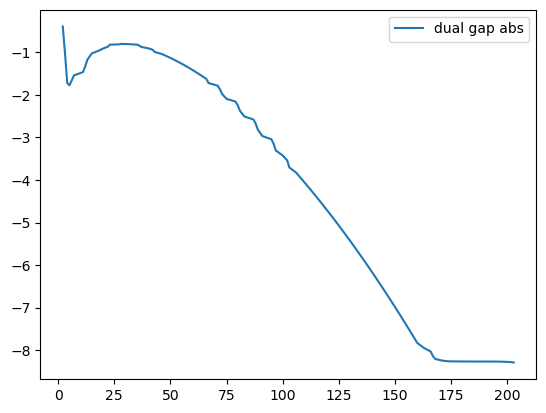

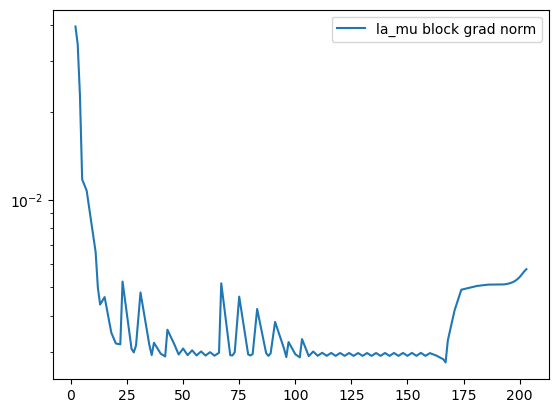

In [11]:
plt.rcParams['figure.dpi']=100
x = results.history_count_calls

plt.plot(x, results.history_dual_gap,  label="dual gap abs")
plt.savefig("plot_ustm_dual_gap.png")
# plt.yscale("log")
plt.legend()
plt.show()

plt.plot(x, results.history_la_mu_grad_norm, label="la_mu block grad norm")
plt.savefig("plot_ustm_la_mu_grad_norm.png")
plt.yscale("log")
plt.legend()
plt.show()


# plt.plot(x, results.history_prime_values, label="history prime function")
# plt.legend()
# plt.show()

# plt.plot(x, results.history_dual_values, label="history dual function")
# plt.legend()
# plt.show()



In [ ]:
# расчет прямой функции
vars = np.zeros(oracle_stacker.parameters_vector_size)  # dual costs w
_ = oracle_stacker(vars)
print("prime function value: ", oracle_stacker.get_prime_value())